In [16]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision

import matplotlib.pyplot as plt
import torchnet as tnt
import random
import copy
import os
import math
import time
import numpy as np
from sklearn.neighbors import NearestNeighbors
from numpy.linalg import multi_dot
from scipy.sparse.linalg import cg
from scipy.sparse import csr_matrix, identity, diags
import faiss
from IPython.display import display
from easydict import EasyDict as edict
from progressbar import ProgressBar
from bayes_opt import BayesianOptimization

%config InlineBackend.figure_format = 'retina'
import os
os.environ['CUDA_VISIBLE_DEVICES']='2'

# Label file location, we want to keep labels fixed for all experiments and want them to be BALANCED, 
# so we store them in disk. 

# Labels = "/data02/Atin/mean-teacher/pytorch/data-local/labels/cifar10/1000_balanced_labels/00.txt"
Labels = "/data02/Atin/mean-teacher/pytorch/data-local/labels/cifar10/250_balanced_labels/00.txt" 

# Location of pretrained unsupervised model
model_state_loc = "/data02/Atin/SSL_LP/Unsupervised_Embedding_Learning/checkpoint/cifar_batch_0nn_128_temp_0.1_km_1_alr_best.t"

In [17]:
#Resnet 18 model used for feature extraction 

class Normalize(nn.Module):
    '''Normalize layer which places the feature on 128 dimensional sphere.
    
    Attributes:
        power: default is 2, which does L2 normalization
    '''
    def __init__(self, power=2):
        super(Normalize, self).__init__()
        self.power = power
    
    def forward(self, x):
        norm = x.pow(self.power).sum(1, keepdim=True).pow(1./self.power)
        out = x.div(norm)
        return out
    
class BasicBlock(nn.Module):
    '''Basic resnet block'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, pool_len =4, low_dim=128):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, low_dim)
        self.l2norm = Normalize(2)
        self.pool_len = pool_len
        # for m in self.modules():
            # if isinstance(m, nn.Conv2d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
            # elif isinstance(m, nn.BatchNorm2d):
                # m.weight.data.fill_(1)
                # m.bias.data.zero_()
                

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, self.pool_len)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = self.l2norm(out)
        return out


def ResNet18(pool_len = 4, low_dim=128):
    return ResNet(BasicBlock, [2,2,2,2], pool_len, low_dim)



In [18]:
def sem_sup_feature(conv_model:nn.Module, dl: torch.utils.data.dataloader):
    '''Extracts features from images using pretrained model
    
    Args:
        dl: dataloader
        conv_model: pretrained nn.Module object 
    
    Returns:
        Tuple[list1, list2]
        list1: 2D torch tensor of size (no. of observation, embedding dim) 
        list2: 1D array of corresponding labels 
    '''
    conv_model.eval()
    semi_supervised_feature_list = []
    label_list = []
    for b in dl:
        data, label = b
        data = data.cuda()
        with torch.no_grad():
            out = conv_model(data)
            b_size = out
            semi_supervised_feature_list.append(out)
            label_list.append(label)
    final_list = torch.cat(semi_supervised_feature_list, dim=0)
    final_label_list = torch.cat(label_list, dim=0)
    return final_list, final_label_list

def return_train_labels_index(labels_loc):
    '''Reads the labels from a file 
    
    Please look at the file in the location to understand the format.
    
    Args:
        labels_loc: Location of the file which contains indices of the labels (e.g. 250 labels).
    
    Returns:
        numpy array of the index of the labels. 
    '''
    label_list = []
    with open(labels_loc, 'r') as df:
        for l in df.readlines():
            label_list.append(int((l.split("_")[0])))

    return np.array(label_list)

def jacobi(D, R, b, no_of_iteration=25, x=None): # Didn't use
    
    if x is None:
        x = zeros(R.shape[0])
    
    for _ in range(N):
        x = (b - dot(R,x)) / D
        
    return x

In [19]:
#load the pre trained model 
state = torch.load(model_state_loc) 
trained_model = ResNet18()
trained_model = torch.nn.DataParallel(trained_model, device_ids=range(torch.cuda.device_count()))
trained_model.load_state_dict(state['net'])
trained_model = trained_model.cuda()

In [20]:
#create data loaders
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
testset = torchvision.datasets.CIFAR10(root='/data02/Atin/CIFAR10/', train=False,
                                           download=True, transform=transform_test)
trainset = torchvision.datasets.CIFAR10(root='/data02/Atin/CIFAR10/', train=True,
                                            download=True, transform=transform_test)

combined_dataset = torch.utils.data.ConcatDataset([trainset, testset])
combined_dataloader = torch.utils.data.DataLoader(combined_dataset, batch_size=1024, shuffle=False, num_workers=20)


#Get the features
SAVED_PATH = 'stored/CIFAR10_feature_label.t'
FORCE_SAVE = False # True if we want to regenerate features and save, else, it will load currently saved features 
# Get the features 
if os.path.exists(SAVED_PATH) and not FORCE_SAVE:
    feature_dict = torch.load(SAVED_PATH)
    feature_mat, label_arr = feature_dict['feature_mat'], feature_dict['label_array']
else:
    feature_mat, label_arr = sem_sup_feature(trained_model, combined_dataloader)
    feature_mat, label_arr = feature_mat.cpu().numpy(), label_arr.cpu().numpy()
    feature_dict = {'feature_mat': feature_mat, 'label_array': label_arr}
    torch.save(feature_dict, SAVED_PATH)

Files already downloaded and verified
Files already downloaded and verified


Files already downloaded and verified
Files already downloaded and verified


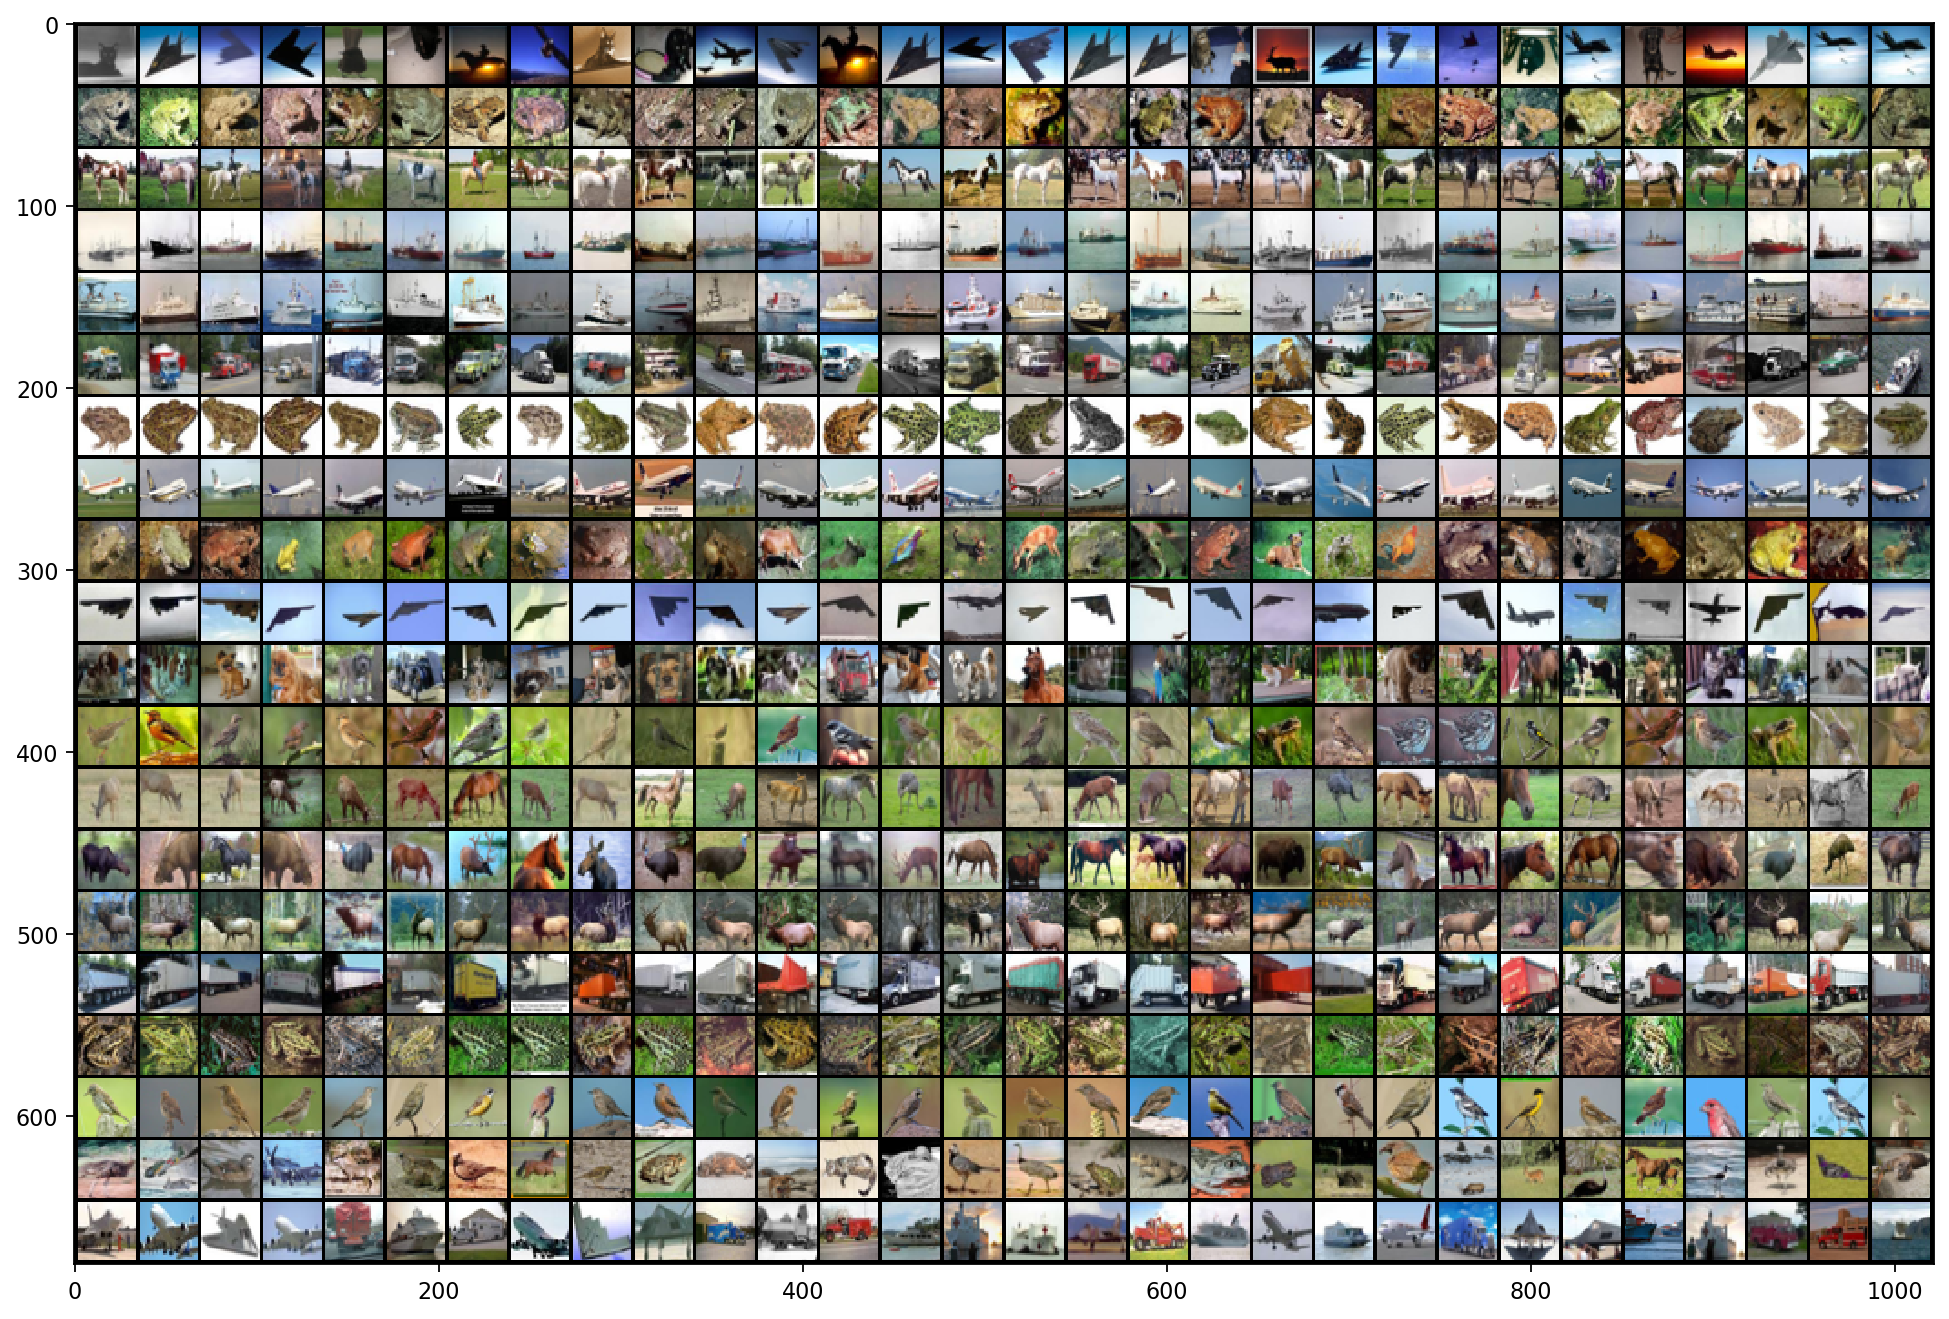

In [122]:
# Plots 30 nearest neigbor based on cosine similiarity for randomly selected rn no. of images from 60k images.
# In the leftmost cplumn we have query image

rn = 20
num_nearest_neighbor = 30

embedding_dim = 128
index = faiss.IndexFlatIP(embedding_dim)
index.add(feature_mat)
distances, indices = index.search(feature_mat, num_nearest_neighbor)

def show(img):
    npimg = img.numpy()
    plt.figure(figsize=(15,20), dpi=80)
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

# Create dataset without any transformation for plotting 
cifar10_dataset_test = torchvision.datasets.CIFAR10("/data02/Atin/data/cifar10/", train=False, transform=transforms.ToTensor(), download=True)
cifar10_dataset_train = torchvision.datasets.CIFAR10("/data02/Atin/data/cifar10/", train=True, transform=transforms.ToTensor(), download=True)
cifar10_combined_dataset = torch.utils.data.ConcatDataset([cifar10_dataset_train, cifar10_dataset_test])


sample_index = random.sample(list(np.arange(len(cifar10_combined_dataset))), rn) # Sample rn indexes in (0, 60000)
sample_data = indices[sample_index].flatten()
images = torch.cat([cifar10_combined_dataset[i][0].unsqueeze(0) for i in sample_data])

grid = torchvision.utils.make_grid(images, nrow=num_nearest_neighbor)
show(grid)

In [21]:
train_label_index_lp = return_train_labels_index(Labels)
unlabel_index_lp = list(set(range(60000)) - set(train_label_index_lp))

Mat_Label = feature_mat[train_label_index_lp] #Labelled data matrix
labels = label_arr[train_label_index_lp] #Corresponding labels of Labelled data matrix

Mat_Unlabel = feature_mat[unlabel_index_lp] #UnLabelled data matrix
rest_label = label_arr[unlabel_index_lp] #Rest of the lable, won't be used

In [22]:
def buildGraph(MatX, trns, knn_num_neighbors=20, dim=128) -> csr_matrix:
    '''creates the affinity matrix from the fearure matrix
    
    MatX has a particular structure. 
    
    Args:
        Matx: feature matrix of shape (num_observation, embedding_dimension). It must have the following structure.
        The first 250 rows (assuming our SSL is trained on 250 labels) will have features corresponding to 250
        labelled examples and remaining rows will be features for unlabelled examples.
        
        trns(function object): transformation for every element of affinity matrix e.g. lambda x: 0 if x < 0 else x**4
        knn_num_neighbors: # of nearest neighbors
        
        dim: embedding dimension
    
    Returns:
        sparse affinity matrix to be used for label propagation later, where labelled examples are stacked at the
        front rows. This is required for label propagation function to work properly. 
    '''
    
    num_samples = MatX.shape[0]
    index = faiss.IndexFlatIP(dim)
    index.add(MatX)
    distances, indices = index.search(MatX, knn_num_neighbors)

    trns = np.vectorize(trns)

    row = np.repeat(np.arange(num_samples), knn_num_neighbors)
    col = indices.flatten()
    data = distances.flatten()
    data = trns(data)
    sp_affinity_matrix = csr_matrix((data, (row, col)), shape=(num_samples, num_samples))
    sp_affinity_matrix = (sp_affinity_matrix + sp_affinity_matrix.transpose())/2
    return sp_affinity_matrix


def labelPropagation(sp_affinity, Mat_Label, Mat_Unlabel, labels, alpha=.1) -> np.array:
    '''Propagates the label to get the prefiction for all unlabelled observations
    
    Args:
        sp_affinity: Sparse affinity matrix of shape (num_observation, num_observation).It must have the following structure.
        The first 250 rows (assuming our SSL is trained on 250 labels) will be corresponding to 250
        labelled examples and remaining rows will be corresponding to unlabelled examples.
        
        Mat_Label: Feature matrix corresponding to lablled obs.
        
        Mat_Unlabel: Feature matrix corresponding to unlablled obs.
        
        labels: labels for each row in Mat_Label
    
    
    Returns:
        predicted labels for all rows of Mat_Unlabel
    '''
    
    # initialize
    num_label_samples = Mat_Label.shape[0]
    num_unlabel_samples = Mat_Unlabel.shape[0]
    num_samples = num_label_samples + num_unlabel_samples
    labels_list = np.unique(labels)
    num_classes = len(labels_list)

    clamp_data_label = np.zeros((num_label_samples, num_classes), np.float32)
    for i in range(num_label_samples):
        clamp_data_label[i][labels[i]] = 1.0

    label_function = np.zeros((num_samples, num_classes), np.float32)
    label_function[0: num_label_samples] = clamp_data_label
    label_function[num_label_samples: num_samples] = 0
    
    degree_vec = np.sum(sp_affinity, axis=1)
    degree_vec_to_the_power_minus_half = 1/np.sqrt(degree_vec)
    sp_degree_matrix_2_the_power_minus_half = diags(np.array(degree_vec_to_the_power_minus_half).flatten())

    sp_d_minus_half_w_d_minus_half = sp_degree_matrix_2_the_power_minus_half @ sp_affinity @ sp_degree_matrix_2_the_power_minus_half

    sparse_matrix = identity(num_samples, format="csr") - alpha * sp_d_minus_half_w_d_minus_half
    
    
    
    
    normalization_diag = diags(np.array(1. / degree_vec).flatten())
    P = normalization_diag @ sp_affinity
    n_iter = 20
    label_function_prop = np.copy(label_function)
    for k in range(n_iter):
        label_function_prop = P @ label_function_prop
        label_function_prop[:num_label_samples] = clamp_data_label
        unlabel_data_labels = np.argmax(label_function_prop, axis=1)
        unlabel_data_labels = unlabel_data_labels[num_label_samples:]
        print(acc(unlabel_data_labels, rest_label) )
        
        
        
        
    
    solution_list = []
    
    pbar = ProgressBar()
    for i in pbar(range(num_classes)):
        converged_solution = cg(sparse_matrix, label_function[:,i])[0]
        converged_solution = np.reshape(converged_solution, (-1,1))
        solution_list.append(converged_solution)
    label_function = np.hstack(solution_list)

    unlabel_data_labels = np.zeros(num_unlabel_samples)
    for i in range(num_unlabel_samples):
        unlabel_data_labels[i] = np.argmax(label_function[i + num_label_samples])

    return unlabel_data_labels

def acc(predicted_labels, true_labels):
    '''returns accuracy'''
    
    corrects = 0
    num_samples = len(predicted_labels)
    for i in range(num_samples):
        if predicted_labels[i] == true_labels[i]:
            corrects +=1
    return corrects/num_samples

In [23]:
# Example of how to do label propagation
start_time = time.time()
# Two types of disnatce function
def trns(x): # taken from this paper https://arxiv.org/pdf/1904.04717.pdf
    return 0 if x < 0 else x**1

def trns1(x): # this is more traditionally used 
    distance = (1-x)/2
    return math.exp(-(distance**2)/.01)

#Stacking features from labelled examples at the begining
MatX = np.vstack((Mat_Label, Mat_Unlabel))
MatX = MatX / np.linalg.norm(MatX, axis=-1)[:, np.newaxis] # not really required since norm of feature is already 1

affinity_matrix = buildGraph(MatX, trns1, 20) # creating sparse affinity matrix
affinity_matrix_time = time.time()
unlabel_data_labels = labelPropagation(affinity_matrix, Mat_Label, Mat_Unlabel, labels, alpha=.97) # Doing LP 

accuracy = acc(unlabel_data_labels, rest_label) # Measuring accuracy 
time_taken = time.time() - start_time
print(f"Accuracy is {accuracy:.2f} and time for affinity matrix {affinity_matrix_time - start_time:.0f} seconds, label propagation time {time.time() - affinity_matrix_time:.0f} seconds")


0.16502092050209205
0.5554644351464435
0.6867782426778243
0.702560669456067
0.7121506276150628
0.7193472803347281
0.7251548117154811
0.7299414225941423
0.7341589958158996
0.7374393305439331
0.7405188284518829
0.7433974895397489
0.7458410041841004
0.7477991631799163
0.7497071129707112
0.7516987447698745
0.7530376569037657


0.7546610878661087
0.7561506276150628
0.7573556485355648


100% |########################################################################|


Accuracy is 0.77 and time for affinity matrix 2 seconds, label propagation time 25 seconds


In [ ]:
affini

In [ ]:
# Now we will plot accuracy vs alpha for different values of hyperparameter for both the distance function

In [162]:
def LP_final_wrapper(num_neighbor, transform="gamma", alpha=.95, gamma=None, tau=None):
    '''wrapper function to combine affinity matrix calculation and LP
    
    Args:
        transform: takes 2 values, "gamma" and "tau" corresponding to different distance function
    
    Returns:
        accuracy and time taken
    
    Raises:
        ValueError: if transform = "gamma" need to provide value of gamma, else need to provide value of tau 
        
    '''
    start_time = time.time()
    global MatX, Mat_Label, Mat_Unlabel, labels, rest_label
    
    if transform == "gamma":
        if gamma is None:
            raise ValueError('need to provide gamma!')
        def trns(x):
            return 0 if x < 0 else x**gamma
        
        sparse_affinity_matrix = buildGraph(MatX, trns, num_neighbor)
        affinity_matrix_time = time.time()
        
    
    if transform == "tau":
        if tau is None:
            raise ValueError('need to provide tau!')
        def trns(x):
            distance = (1-x)/2
            return math.exp(-(distance**2)/tau)
        
        sparse_affinity_matrix = buildGraph(MatX, trns, num_neighbor)
        affinity_matrix_time = time.time()
    
    unlabel_data_labels = labelPropagation(sparse_affinity_matrix, Mat_Label, Mat_Unlabel, labels, alpha)

    return acc(unlabel_data_labels, rest_label), affinity_matrix_time - start_time, time.time() - affinity_matrix_time


def function_to_be_optimized_tau(num_neighbor, tau, alpha):
    '''function which will be passed for bayesian optimization'''
    
    num_neighbor = int(num_neighbor)
    return LP_final_wrapper(num_neighbor, transform = "tau", tau=tau, alpha=alpha)[0]

In [ ]:
pbounds = {'num_neighbor': (10, 50), 'tau': (.01, 1), 'alpha': (.93, 1)}
optimizer = BayesianOptimization(
    f=function_to_be_optimized_tau,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer.maximize(init_points=2, n_iter=5)

|   iter    |  target   |   alpha   | num_ne... |    tau    |
-------------------------------------------------------------


100% |########################################################################|


|  1        |  0.7664   |  0.9592   |  38.81    |  0.01011  |


100% |########################################################################|


|  2        |  0.7596   |  0.9512   |  15.87    |  0.1014   |


100% |########################################################################|


|  3        |  0.7463   |  0.997    |  49.99    |  0.9792   |


In [161]:
LP_final_wrapper(15, transform = "tau", tau=.03, alpha=.93)

100% |########################################################################|


(0.7572050209205021, 3.1023895740509033, 21.733371019363403)